# EXAMPLE 

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [4]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline


# Trial on Day-ahead data

So what is going to happen is as follows:

0. Try to plot day-ahead price
1. Try fit a periodic spline on day-ahead data
2. Pick 5 spots on the day-ahead price and add noise to it. Then fit a periodic spline function to it afterwards

Open the real.csv file and the day-ahead

### Loading data

In [27]:
# data = pd.read_csv('C:\\Users\\Daniel  BV\\Desktop\\Thesis\\Code\\Function_Folder\\Input\\real.csv')
path = 'C:\\Users\\junes\\Desktop\\DTU MSc\\MSc thesis\\MSc thesis codes\\Processed_data\\real.csv'
data = pd.read_csv(path)
spot = data["Spot"].to_numpy()
spot_reshape = np.reshape(spot, (24, 90+365),order ='F') # F to ensure the correct reshaping.
spot_reshaped_forecasted = spot_reshape[:,365:]
mean_spot_all_days = np.mean(spot_reshaped_forecasted,axis=1)
std_spot_all_days = np.std(spot_reshaped_forecasted,axis = 1)


print(np.shape(spot_reshape[:,365:]))


(24, 90)


## Deciding on the training data

Text(0.5, 1.0, 'Mean Spot price ')

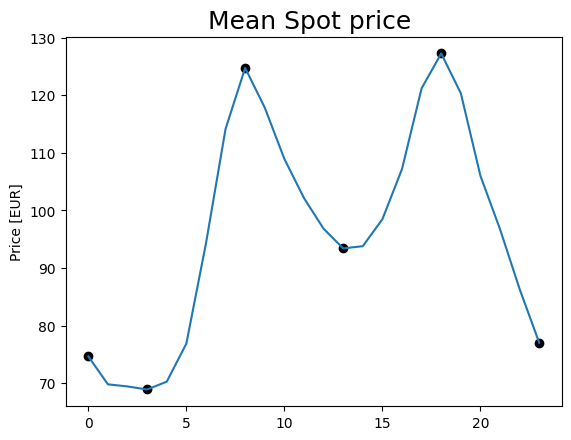

In [9]:
x_train = np.array([0,3,8,13,18,23])
y_train = mean_spot_all_days[x_train]
plt.plot(mean_spot_all_days)
plt.scatter(x_train, y_train,c='black', label="training points")
plt.ylabel("Price [EUR]")

# Set the plot title
title = "Mean Spot price "
plt.title(title, fontsize=18)

## Approximate with spline function

In [10]:
x_train = np.array([0,3,8,13,18,23]) # Data which is traded upon
X_train = x_train[:, np.newaxis] # necessary for the scikit method to work
y_train = spot_reshaped_forecasted[x_train,1]

x_plot = np.arange(24) # For plotting purposes
X_plot = x_plot[:, np.newaxis]


Building the model:

In [11]:

model = make_pipeline(SplineTransformer(n_knots=6, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)


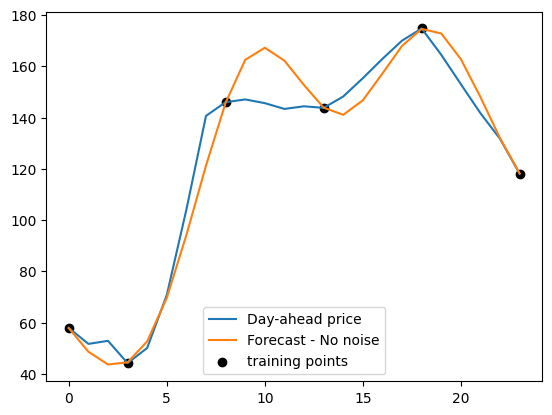

In [12]:
plt.plot(spot_reshaped_forecasted[:,1],label = "Day-ahead price")
plt.plot(y_plot,label = "Forecast - No noise")
plt.scatter(x_train, y_train,c='black', label="training points")
plt.legend(loc="lower center")

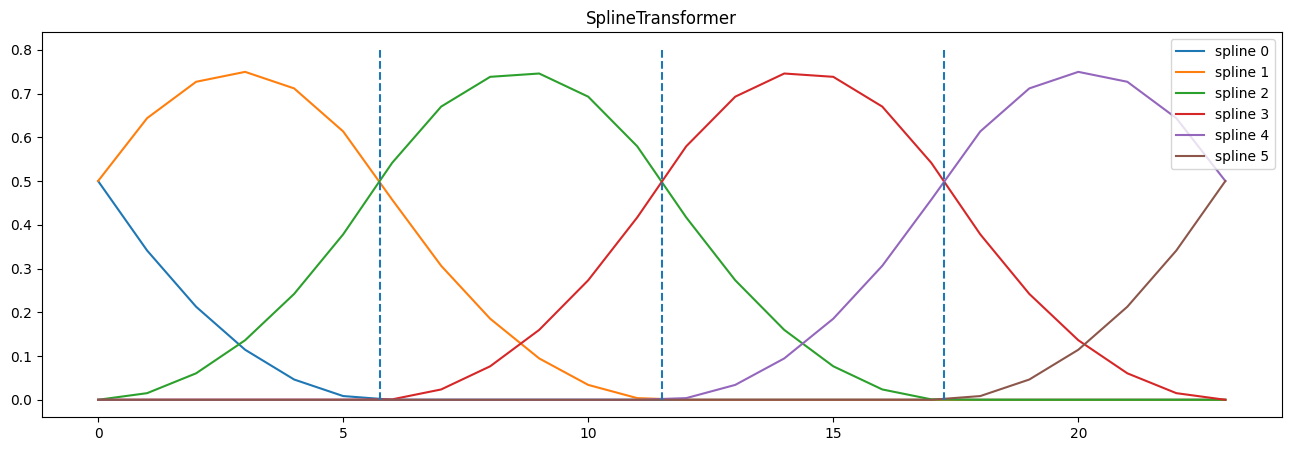

In [13]:
fig, axes = plt.subplots(ncols=1, figsize=(16, 5))

splt = SplineTransformer(n_knots=5, degree=2).fit(X_train)
axes.plot(x_plot, splt.transform(X_plot))
axes.legend(axes.lines, [f"spline {n}" for n in range(6)])
axes.set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes.vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

# ADDING NOISE TO CREATE THE FORECASTS

First we assess the standard deviation of the time instances of our data, because then we know how much noise we should add.


In [14]:
print(np.reshape(std_spot_all_days[x_train],(6,1)))

[[44.59919174]
 [44.33765783]
 [59.98360161]
 [45.64464177]
 [55.60187293]
 [44.49921285]]


However the standard deviation is way too much, so let us take a percentage of it. For

- D-2, 30 %
- DA, 20 %
- D-1, 10 %

In [15]:
std_train = std_spot_all_days[x_train]*0.1
print(std_train)
print(np.shape(std_train))

[4.45991917 4.43376578 5.99836016 4.56446418 5.56018729 4.44992128]
(6,)


In [16]:
std_train = std_spot_all_days[x_train]*0.1
noise = np.random.normal(0, std_train, std_train.shape)
print(np.shape(noise))
print(noise)

(6,)
[-7.06376803 -7.20635136 -1.73293841  7.36880284 -3.2055732  -1.04412771]


In [17]:
def Forecast_of_spot(Spot_data):

    '''
    
    Spot_data (dataframe). NEED TO BE DIVISIBLE OF 24

    '''

    # Load the data
    spot = Spot_data.to_numpy() # Transform to numpy
    spot_reshape = np.reshape(spot, (24, int(len(spot)/24)),order ='F') # F to ensure the correct reshaping
    mean_spot_all_days = np.mean(spot_reshape,axis=1)
    std_spot_all_days  = np.std(spot_reshape  ,axis = 1)

    # Set the training data settings
    x_train = np.array([0,3,8,13,18,23]) # Data which is traded upon
    X_train = x_train[:, np.newaxis] # necessary for the scikit method to work

    # Construct the noise
    std_train_D_2 = std_spot_all_days[x_train]*0.2
    std_train_D_1 = std_spot_all_days[x_train]*0.1
    noise_D_2 = np.random.normal(0, std_train_D_2, std_train_D_2.shape)
    noise_D_1 = np.random.normal(0, std_train_D_1, std_train_D_1.shape)

    # Set up the calculated parts
    True_Spot= spot_reshape 
    Forecast_no_noise = np.zeros((24,90))
    Forecast_D_2 = np.zeros((24,90))
    Forecast_D_1 = np.zeros((24,90))


 
   # Set up settings for the Spline interpolation
    x_day = np.arange(24) # For plotting purposes
    X_day = x_day[:, np.newaxis]

    model = make_pipeline(SplineTransformer(n_knots=6, degree=3), Ridge(alpha=1e-3))

    days = len(True_Spot[0,:])
    for d in range(0,days):

        # Forecast with noise, at D-2. Two days prior
        y_train_D_2 = True_Spot[x_train,d] + noise_D_2
        model.fit(X_train, y_train_D_2) 
        y_day = model.predict(X_day) 
        Forecast_D_2[:,d] = np.reshape(y_day, (24,) ) # Save the forecast

        # Forecast with noise, at D-1. One days prior
        y_train_D_1 = True_Spot[x_train,d] + noise_D_1
        model.fit(X_train, y_train_D_1) 
        y_day = model.predict(X_day) 
        Forecast_D_1[:,d] = np.reshape(y_day, (24,) ) # Save the forecast

        # Forecast without noise
        model.fit(X_train, spot_reshape[x_train,d]) 
        y_day = model.predict(X_day)
        Forecast_no_noise[:,d] = np.reshape(y_day, (24,) ) # Save the forecast


    
    return Forecast_D_2, Forecast_D_1, Forecast_no_noise, True_Spot

In [18]:
spot[(24*365):]

array([ 2.01    ,  1.38    ,  0.09    , ..., 40.93    , 35.849998,
       30.040001])

In [19]:
Forecast_D_2, Forecast_D_1, Forecast_no_noise, True_Spot = Forecast_of_spot(data["Spot"].loc[(24*365):])

Visualize the forecasts

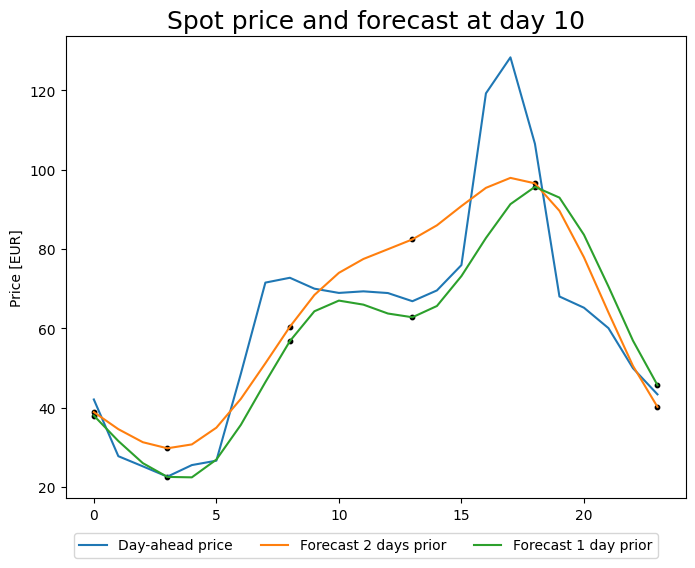

In [20]:

# Set the font size of the plot
plt.rcParams.update({'font.size': 10})

# Set the figure size and dpi
fig = plt.figure(figsize=(8, 6), dpi=100)

# Plot the data
d = 10
plt.plot(True_Spot[:,d],  label="Day-ahead price")
plt.plot(Forecast_D_2[:,d],  label="Forecast 2 days prior")
plt.plot(Forecast_D_1[:,d],  label="Forecast 1 day prior")
plt.scatter(x_train, Forecast_D_2[x_train,d], c='black', s=10)
plt.scatter(x_train, Forecast_D_1[x_train,d], c='black', s=10)

# Add a legend outside of the plots
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

plt.ylabel("Price [EUR]")

# Set the plot title
title = "Spot price and forecast at day {}".format(d)
plt.title(title, fontsize=18)

# Show the plot

plt.savefig('Spot_Forecast.png')
plt.show()


## Percentage difference:

In [21]:
(True_Spot[:,1] - Forecast_D_2[:,1])/True_Spot[:,1]

array([ 0.05449084,  0.04460474,  0.09074416, -0.16385665, -0.19629988,
       -0.04789175,  0.10589516,  0.19034236,  0.08506737, -0.01422842,
       -0.08561178, -0.12446883, -0.11393935, -0.10834135, -0.0731853 ,
       -0.03713584, -0.00683679,  0.02440565,  0.05705078,  0.03302843,
        0.02580134,  0.03338708,  0.05194535,  0.02708331])

In [22]:
True_Spot - Forecast_D_2

array([[ 3.07527169e+00,  3.15556468e+00,  3.14747866e+00, ...,
         3.14510416e+00,  3.23384220e+00,  3.12097035e+00],
       [-1.27264964e-01,  2.30472679e+00,  8.67134172e-01, ...,
        -1.59297250e+00, -2.99315216e+00,  2.99004471e+00],
       [-4.50738642e+00,  4.79673628e+00, -1.60773609e-02, ...,
        -2.91217543e+00, -4.08309137e+00,  1.15838159e+01],
       ...,
       [ 5.86074064e+00,  4.72994694e+00,  1.55425802e+01, ...,
         3.20097888e+00,  2.69568060e+01, -1.31211586e+01],
       [ 1.04915643e+01,  6.83964375e+00,  1.33585421e+01, ...,
         9.54746059e+00,  1.65289085e+01, -2.20312048e+00],
       [ 3.25607526e+00,  3.19745592e+00,  3.14207850e+00, ...,
         3.16453461e+00,  3.15912282e+00,  3.11110171e+00]])

In [23]:
Forecast_D_2, Forecast_D_1, Forecast_no_noise, True_Spot

(array([[ -1.06527169,  54.75443532,  75.66251934, ...,  92.04489784,
          86.4761568 ,  34.11903165],
        [  1.50726496,  49.36527121,  73.06286583, ...,  93.7429745 ,
          85.24315216,  37.08995729],
        [  4.59738642,  48.06326472,  73.95607936, ...,  97.71217843,
          84.83309137,  44.14618413],
        ...,
        [ 39.12926136, 136.94005106, 115.50742281, ..., 111.71901912,
          73.84319702,  54.05115864],
        [ 35.46843469, 124.83035425, 100.91145489, ..., 100.35254141,
          64.24108851,  38.05311848],
        [ 31.74392474, 114.86254208,  90.5179255 , ...,  91.63546839,
          56.87087618,  26.92889929]]),
 array([[ -1.93817542,  53.88153159,  74.78961561, ...,  91.17199411,
          85.60325307,  33.24612792],
        [ -1.48547653,  46.37252971,  70.07012434, ...,  90.75023301,
          82.25041067,  34.0972158 ],
        [ -0.67941572,  42.78646259,  68.67927723, ...,  92.4353763 ,
          79.55628924,  38.869382  ],
        ...,


Save it all into one dataframe:

In [24]:
True_Spot_reshaped = pd.DataFrame(np.reshape(True_Spot, (24*90,), order = 'F'),columns=["Spot"])

Forecast_D_2_reshaped = pd.DataFrame(np.reshape(Forecast_D_2, (24*90,), order = 'F'),columns=["Spot_D_2"])
Forecast_D_1_reshaped = pd.DataFrame(np.reshape(Forecast_D_1, (24*90,), order = 'F'),columns=["Spot_D_1"])







# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [29]:
data = pd.read_csv(path)
data_cop = data.copy()
data = data.drop(columns=["Hour"])
setup_forecast = data_cop.drop(columns=["Hour","Spot"])
True_data = data.loc[8760:].reset_index(drop=True)
True_data.columns
Spot_data = True_data['Spot']


In [30]:

Total_length_test = len(data["FD1_down"]) - 8760
# Create an empty dataframe with the same columns as `data`
forecasted_data_D_2 = pd.DataFrame(columns=setup_forecast.columns, index=range(Total_length_test))
forecasted_data_D_1 = pd.DataFrame(columns=setup_forecast.columns, index=range(Total_length_test))
print(forecasted_data_D_2.columns)

Index(['FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage',
       'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage',
       'FD_act_up', 'FD_act_down'],
      dtype='object')


In [31]:

D_2_list = 24*[3,4,5,6,7]
D_1_list = 24*[2,3,4,5,6]
for col in data.columns:
    if col == "Spot":
        # Run spline procedure
        # Use True_data
        print("Spot started")
        Forecast_Spot_D_2, Forecast_Spot_D_1, Forecast_Spot_no_noise, True_Spot = Forecast_of_spot(Spot_data)
        print("Spot ended")
    else: 
        # Run mean procedure
        for h in range(0,Total_length_test):
            
            # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
            if 'percentage' in col:
                if "FD2" in col:
                    if "up" in col:
                        forecasted_data_D_2[col].loc[h] = 1 - forecasted_data_D_2['FD1_up_percentage'].loc[h]
                        forecasted_data_D_1[col].loc[h] = 1 - forecasted_data_D_1['FD1_up_percentage'].loc[h]
                    else:
                        forecasted_data_D_2[col].loc[h] = 1 - forecasted_data_D_2['FD1_down_percentage'].loc[h]
                        forecasted_data_D_1[col].loc[h] = 1 - forecasted_data_D_1['FD1_down_percentage'].loc[h]
                else:
                    forecasted_data_D_2[col].loc[h] = np.mean([data[col].loc[h+8760-hd] for hd in D_2_list])
                    forecasted_data_D_1[col].loc[h] = np.mean([data[col].loc[h+8760-hd] for hd in D_1_list])

            else:
                # Otherwise forecast the price or activation as what the mean is of the specific hour 1 to 5 days ago.
                forecasted_data_D_2[col].loc[h] = np.mean([data[col].loc[h+8760-hd] for hd in D_2_list])
                forecasted_data_D_1[col].loc[h] = np.mean([data[col].loc[h+8760-hd] for hd in D_1_list])

                
        

Spot started
Spot ended


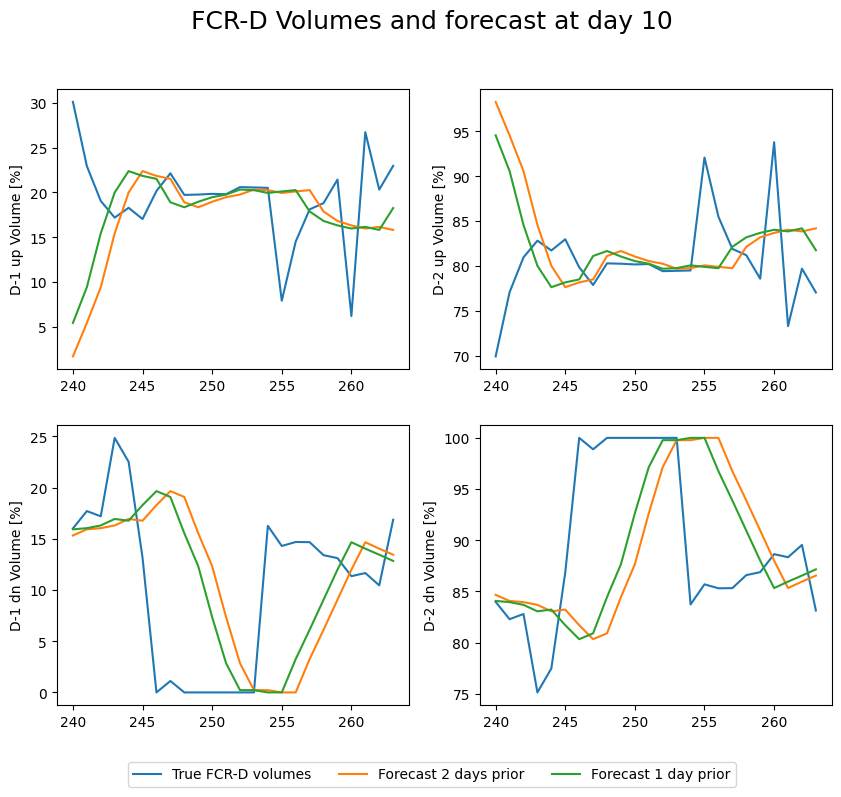

In [32]:
True_FCRD_vol = data[["FD1_down_percentage","FD2_down_percentage","FD1_up_percentage","FD2_up_percentage"]].loc[8760:].reset_index(drop=True)


fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_FCRD_vol.columns):
    ax = axs[i // 2, i % 2]
    ax.plot(True_FCRD_vol[col].iloc[int(0+float(d)*24):int(24+float(d)*24)]*100, label="True FCR-D volumes")
    ax.plot(forecasted_data_D_2[col].iloc[int(0+float(d)*24):int(24+float(d)*24)]*100, label="Forecast 2 days prior")
    ax.plot(forecasted_data_D_1[col].iloc[int(0+float(d)*24):int(24+float(d)*24)]*100, label="Forecast 1 day prior")
    ax.set_ylabel(col)

axs[0,0].set_ylabel('D-1 up Volume [%]') 
axs[0,1].set_ylabel('D-2 up Volume [%]') 
axs[1,0].set_ylabel('D-1 dn Volume [%]') 
axs[1,1].set_ylabel('D-2 dn Volume [%]') 


# Add a legend outside of the plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "FCR-D Volumes and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('FCR-D_Forcasts_volumes.png')

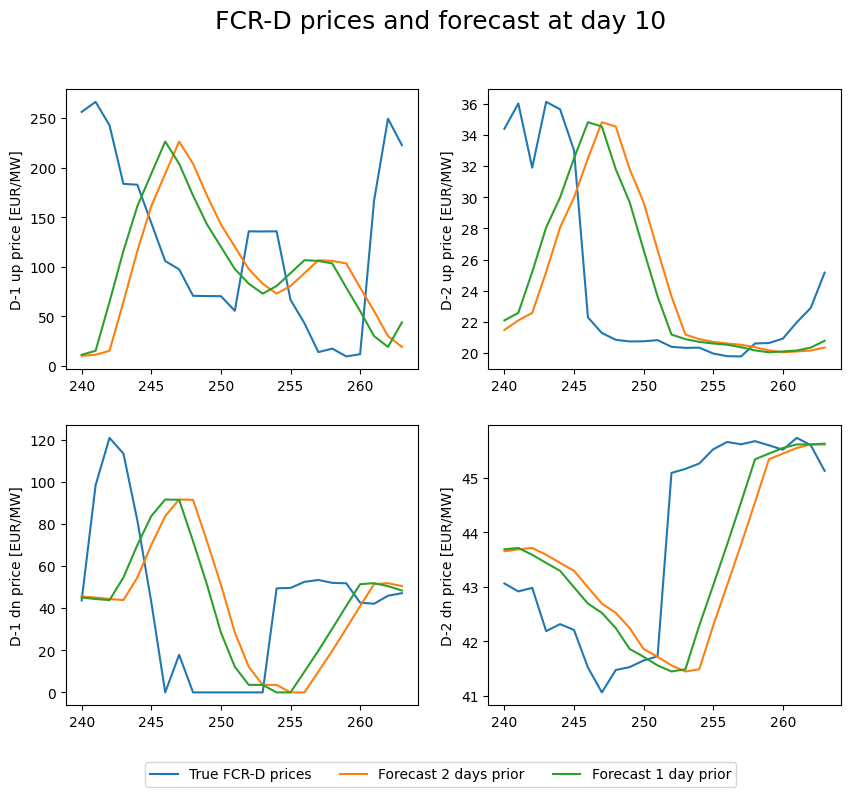

In [33]:
True_FCRD = data[["FD1_down","FD2_down","FD1_up","FD2_up"]].loc[8760:].reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_FCRD.columns):
    ax = axs[i // 2, i % 2]
    ax.plot(True_FCRD[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="True FCR-D prices")
    ax.plot(forecasted_data_D_2[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 2 days prior")
    ax.plot(forecasted_data_D_1[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 1 day prior")
    ax.set_ylabel(col)

axs[0,0].set_ylabel('D-1 up price [EUR/MW]') 
axs[0,1].set_ylabel('D-2 up price [EUR/MW]') 
axs[1,0].set_ylabel('D-1 dn price [EUR/MW]') 
axs[1,1].set_ylabel('D-2 dn price [EUR/MW]') 


# Add a legend outside of the plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "FCR-D prices and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('FCR-D_Forcasts_prices.png')

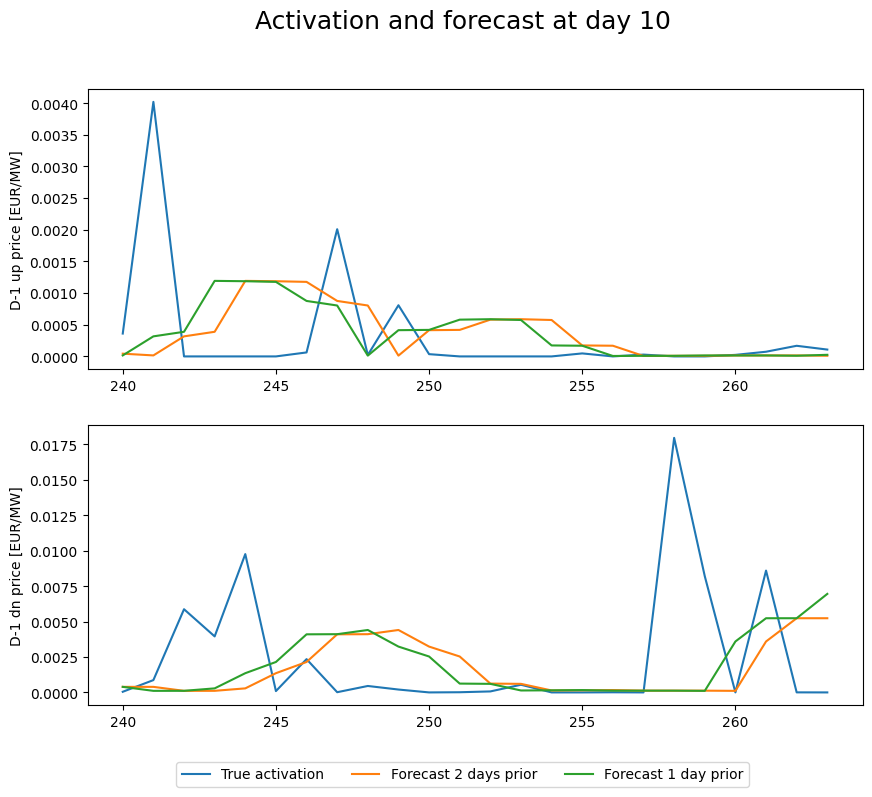

In [34]:
True_act = data[["FD_act_up","FD_act_down"]].loc[8760:].reset_index(drop=True)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_act.columns):
    ax = axs[i]
    ax.plot(True_act[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="True activation")
    ax.plot(forecasted_data_D_2[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 2 days prior")
    ax.plot(forecasted_data_D_1[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 1 day prior")
    ax.set_ylabel(col)

axs[0].set_ylabel('D-1 up price [EUR/MW]')  
axs[1].set_ylabel('D-1 dn price [EUR/MW]')


# Add a legend outside of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "Activation and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('Activation_Forecasts.png')

# Create a csv file for forecasted values of D-2

In [35]:
True_data.shape
forecasted_data_D_2.shape
True_Spot_reshaped.shape
Forecast_D_2_reshaped.shape

(2160, 1)

In [36]:

forecasted_data_D_2 = forecasted_data_D_2
Forecast_Spot_D_2_reshaped = pd.DataFrame(np.reshape(Forecast_Spot_D_2, (24*90,), order = 'F'),columns=["Spot"])
print(forecasted_data_D_2.columns)
print(Forecast_Spot_D_2_reshaped.columns)
forecast_D_2_comb = pd.concat([Forecast_Spot_D_2_reshaped, forecasted_data_D_2], axis=1)
print(forecast_D_2_comb.shape)
print(forecast_D_2_comb.columns)

#Create csv
forecast_D_2_comb.to_csv("Processed_data/forecast.csv",index=False)

Index(['FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage',
       'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage',
       'FD_act_up', 'FD_act_down'],
      dtype='object')
Index(['Spot'], dtype='object')
(2160, 11)
Index(['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage',
       'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage',
       'FD_act_up', 'FD_act_down'],
      dtype='object')
